In [ ]:

"""
 ADNI1 MRI Image Preprocessing Overview

The ADNI1 MRI images undergo several preprocessing steps before being made publicly available.
 This documentation outlines additional steps applied during our project for organizing and preparing these images for analysis.

---

 Image Folder Naming Convention & Preprocessing Status

ADNI folders named:

* `MPR-R__GradWarp__B1_Correction__N3__Scaled`
* `MPR__GradWarp__B1_Correction__N3__Scaled`

indicate that the following preprocessing has already been performed by ADNI:

GradWarp**: Corrects for gradient non-linearity (geometric distortion).
B1 Correction**: Corrects for B1 field inhomogeneity (ensures uniform intensity).
N3 Bias Field Correction**: Removes low-frequency intensity non-uniformities.
Scaling**: Normalizes image intensity across different scans.

---

 Project-Specific Preprocessing Steps

 For **AD** and **CN** groups:

Select only images from folders:

* `MPR-R__GradWarp__B1_Correction__N3__Scaled` or
* `MPR__GradWarp__B1_Correction__N3__Scaled`

Perform the following preprocessing steps:

1.  Skull Stripping

   * Tool: SynthStrip of FreeSurfer (https://surfer.nmr.mgh.harvard.edu/docs/synthstrip/)
   SynthStrip is a skull-stripping tool that extracts brain voxels from a landscape of image types,
   ranging across imaging modalities, resolutions, and subject populations. It leverages a deep learning strategy to
   synthesize arbitrary training images from segmentation maps, yielding a robust model agnostic to acquisition specifics



---

 For pMCI and sMCI groups:

If the folder name contains:

* `MPR-R__GradWarp__B1_Correction__N3__Scaled` or
* `MPR__GradWarp__B1_Correction__N3__Scaled`

Apply **the same preprocessing steps as AD/CN**.

 If the folder name is:

* `MPR__GradWarp__N3__Scaled` (this means that this image is  missing B1 Correction)

Apply the following steps:

1. N4 Bias Field Correction

   * Tool: [ANTs N4BiasFieldCorrection](https://github.com/ANTsX/ANTs) or [SimpleITK](https://simpleitk.readthedocs.io/)

2. Then apply all AD/CN preprocessing steps:

   * Skull stripping (SynthStrip)
   

---

 Tools Used

| Task                     | Tool/Library     |
| ------------------------ | ---------------- |
| Skull Stripping          | SynthStrip         |
| Bias Field Correction    | SimpleITK / ANTs |


"""


In [3]:

"""
the skull extraction will be done using the Docker image of SynthStrip running it on WSL Ubuntu 




#!/bin/bash

INPUT_DIR="/mnt/c/ADNI_Sorted/CN" # the same for AD, PMCI, SMCI groups 
OUTPUT_BASE="/mnt/c/Adni_processeded/CN" # the same for AD, PMCI, SMCI groups 

# Find all .nii files
find "$INPUT_DIR" -type f -name "*.nii" | while read -r file; do
  # Get relative path after INPUT_DIR
  rel_path="${file#$INPUT_DIR/}"

  # Remove .nii extension and prepare output path
  out_rel_path="${rel_path%.nii}_skullstripped.nii.gz"
  out_path="$OUTPUT_BASE/$out_rel_path"

  # Create output directory if it doesn't exist
  mkdir -p "$(dirname "$out_path")"

  echo "Processing: $file"
  echo "Saving to:  $out_path"

  docker run --rm \
    -v "$INPUT_DIR":/input \
    -v "$OUTPUT_BASE":/output \
    freesurfer/synthstrip \
    -i "/input/$rel_path" \
    -o "/output/$out_rel_path"
"""






"""
after orginazing the iamges and having NeedsBiasPreprocessingPmci NeedsBiasPreprocessingSmci folders that contains a MCI images that need bias correction ,
a bias correction will be done for those images and afterward a skull extracing will be performed too 
"""




Processing: C:\Users\moham\OneDrive\Desktop\study\now\master\DSLab\skull_stripped\skullstripped.nii.gz
Group: AD
Output directory: C:\Users\moham\OneDrive\Desktop\study\now\master\DSLab\skull_stripped
 shape: (256, 256, 166)
 voxel size: (0.9478369, 0.94620186, 1.20282)
Step 3: Skipping bias correction (not needed for this group/image type)
Step 4: Resampling...
After resampling shape: (243, 242, 200)
Step 5: Reshaping to target dimensions...
Final shape: (128, 128, 128)
✅ Successfully processed: C:\Users\moham\OneDrive\Desktop\study\now\master\DSLab\skull_stripped\skullstripped.nii.gz ➜ C:\Users\moham\OneDrive\Desktop\study\now\master\DSLab\skull_stripped\skullstripped_preprocessed.nii

Final processed image saved at: C:\Users\moham\OneDrive\Desktop\study\now\master\DSLab\skull_stripped\skullstripped_preprocessed.nii
Final image shape: (128, 128, 128)
Final voxel size: (0.9478369, 1.0, 1.20282)
Data range: 0.00 to 1202.71


In [ ]:
import os
from pathlib import Path
import nibabel as nib
import SimpleITK as sitk

def n4_bias_correction(input_image):
    sitk_image = sitk.GetImageFromArray(input_image.get_fdata())
    sitk_image = sitk.Cast(sitk_image, sitk.sitkFloat32)
    mask_image = sitk.OtsuThreshold(sitk_image, 0, 1, 200)
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected_image = corrector.Execute(sitk_image, mask_image)
    corrected_array = sitk.GetArrayFromImage(corrected_image)
    return nib.Nifti1Image(corrected_array, input_image.affine)

def process_nested_subjects(input_root, output_root, group):
    input_root = Path(input_root)
    output_root = Path(output_root)

    print(f"\n🔍 Scanning folder: {input_root}")

    nii_files = list(input_root.rglob("*.nii")) + list(input_root.rglob("*.nii.gz"))
    print(f"🔍 Found {len(nii_files)} NIfTI files for group: {group}")

    if len(nii_files) == 0:
        print("⚠️ No files found. Double-check the folder paths and extensions.")
        return

    for nii_path in nii_files:
        try:
            print(f"→ Processing: {nii_path}")

            relative = nii_path.relative_to(input_root)
            parts = relative.parts
            subject_id = parts[0] if len(parts) > 0 else "unknown_subject"
            timepoint = parts[1] if len(parts) > 1 else "unknown_timepoint"

            # Output directory
            subject_output_dir = output_root / subject_id / timepoint
            subject_output_dir.mkdir(parents=True, exist_ok=True)

            # Load and correct
            image = nib.load(nii_path)
            corrected = n4_bias_correction(image)

            # Save
            output_filename = nii_path.stem + "_preprocessed.nii.gz"
            output_path = subject_output_dir / output_filename
            nib.save(corrected, output_path)

            print(f"✅ Saved to: {output_path}")

        except Exception as e:
            print(f"❌ Error processing {nii_path}: {e}")


# --- Define your folders ---
pmci_input = r"C:\ADNI_Sorted\NeedsBiasPreprocessingPmci"
pmci_output = r"C:\ADNI_Sorted\pmciSkullextracting"


smci_input = r"C:\ADNI_Sorted\NeedsBiasPreprocessingSmci"
smci_output = r"C:\ADNI_Sorted\smciSkullExtracting"

# --- Run processing ---
if __name__ == "__main__":
    process_nested_subjects(pmci_input, pmci_output, group="pMCI")
    process_nested_subjects(smci_input, smci_output, group="sMCI")


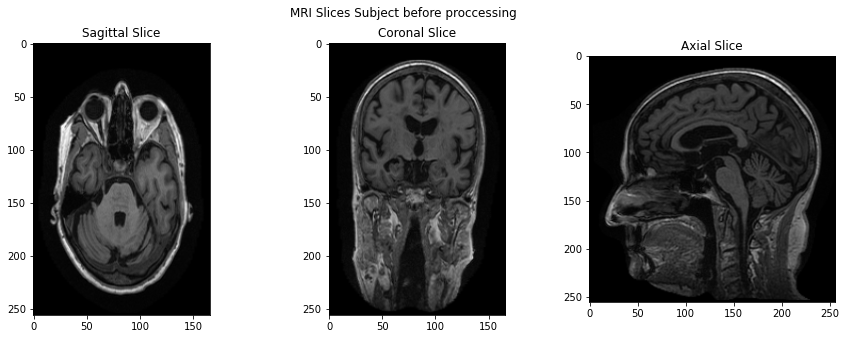

In [2]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load a NIfTI image
img_path = r"C:\Users\moham\OneDrive\Desktop\study\now\master\DSLab\image.nii"
img = nib.load(img_path)
img_data = img.get_fdata()
# Plot middle slice in all 3 dimensions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_data[img_data.shape[0]//2, :, :], cmap='gray')
plt.title('Sagittal Slice')

plt.subplot(1, 3, 2)
plt.imshow(img_data[:, img_data.shape[1]//2, :], cmap='gray')
plt.title('Coronal Slice')

plt.subplot(1, 3, 3)
plt.imshow(img_data[:, :, img_data.shape[2]//2], cmap='gray')
plt.title('Axial Slice')

plt.suptitle('MRI Slices Subject before proccessing')
plt.show()

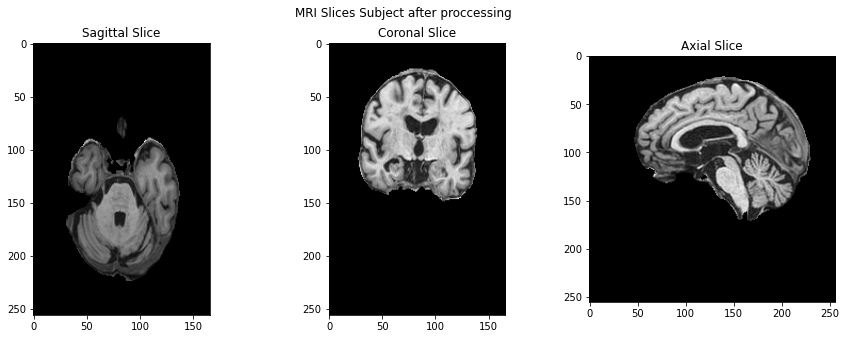

In [2]:
img_path = r"C:\Users\moham\OneDrive\Desktop\study\now\master\DSLab\skull_stripped\skullstripped.nii.gz"
img = nib.load(img_path)
img_data = img.get_fdata()
# Plot middle slice in all 3 dimensions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_data[img_data.shape[0]//2, :, :], cmap='gray')
plt.title('Sagittal Slice')

plt.subplot(1, 3, 2)
plt.imshow(img_data[:, img_data.shape[1]//2, :], cmap='gray')
plt.title('Coronal Slice')

plt.subplot(1, 3, 3)
plt.imshow(img_data[:, :, img_data.shape[2]//2], cmap='gray')
plt.title('Axial Slice')

plt.suptitle('MRI Slices Subject after proccessing')
plt.show()

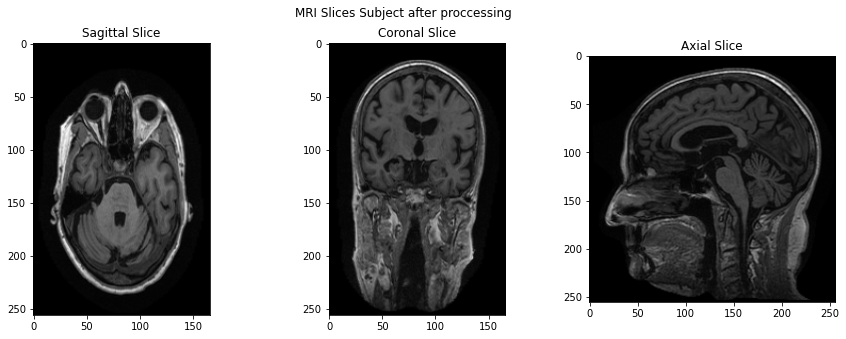

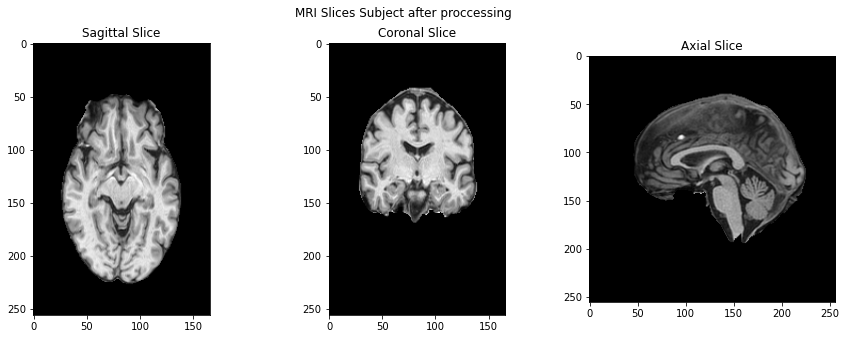

In [6]:
img_path = r"C:\Users\moham\OneDrive\Desktop\study\now\master\DSLab\image.nii"
img = nib.load(img_path)
img_data = img.get_fdata()
# Plot middle slice in all 3 dimensions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_data[img_data.shape[0]//2, :, :], cmap='gray')
plt.title('Sagittal Slice')

plt.subplot(1, 3, 2)
plt.imshow(img_data[:, img_data.shape[1]//2, :], cmap='gray')
plt.title('Coronal Slice')

plt.subplot(1, 3, 3)
plt.imshow(img_data[:, :, img_data.shape[2]//2], cmap='gray')
plt.title('Axial Slice')

plt.suptitle('MRI Slices Subject after proccessing')
plt.show()

img_path = r"C:\Users\moham\OneDrive\Desktop\study\now\master\DSLab\processeded.nii.gz"
img = nib.load(img_path)
img_data = img.get_fdata()
# Plot middle slice in all 3 dimensions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_data[img_data.shape[0]//2, :, :], cmap='gray')
plt.title('Sagittal Slice')

plt.subplot(1, 3, 2)
plt.imshow(img_data[:, img_data.shape[1]//2, :], cmap='gray')
plt.title('Coronal Slice')

plt.subplot(1, 3, 3)
plt.imshow(img_data[:, :, img_data.shape[2]//2], cmap='gray')
plt.title('Axial Slice')

plt.suptitle('MRI Slices Subject after proccessing')
plt.show()